<a href="https://colab.research.google.com/github/Nutritiousfacts/DS-Unit-2-Regression-Classification/blob/master/module3/Gabe_flomo_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [219]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [222]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23035,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,SUNNYSIDE,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,11104.0,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,SUNNYSIDE,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,11377.0,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,WOODHAVEN,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,11421.0,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019
23039,4,WOODSIDE,12 CONDOS - WALKUP APARTMENTS,2,1216,1161,NaN,R2,"61-05 39TH AVENUE, F5",F5,11377.0,1.0,0.0,85.0,"15,151",854.0,1927.0,2,R2,569202,04/30/2019


In [0]:
df = df.query("SALE_PRICE > 100000 and SALE_PRICE < 2000000")  

In [224]:
mask = df['BUILDING_CLASS_CATEGORY'].str.contains("01 ONE FAMILY DWELLINGS")
sub = df[mask]
sub.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23029,4,ROSEDALE,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,SPRINGFIELD GARDENS,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019
23035,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019


In [225]:
sub.columns
sub.columns.drop("EASE-MENT")



Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [226]:
sub["SALE_DATE"] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
sub["SALE_DATE"].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
import numpy as np 

sub = sub[(sub['SALE_PRICE'] >= np.percentile(sub['SALE_PRICE'], 0.5)) & 
        (sub['SALE_PRICE'] <= np.percentile(sub['SALE_PRICE'], 99.5)) & 
        (sub['GROSS_SQUARE_FEET'] >= np.percentile(sub['GROSS_SQUARE_FEET'], 0.05)) & 
        (sub['GROSS_SQUARE_FEET'] < np.percentile(sub['GROSS_SQUARE_FEET'], 99.95))]

In [0]:
sub = sub.query("GROSS_SQUARE_FEET > 0")

In [229]:
sub["SALE_DATE"].dt.month.value_counts()

1    924
3    782
2    749
4    630
Name: SALE_DATE, dtype: int64

In [230]:
shape = 907 + 763 + 734
shape

2404

In [231]:
train = sub[sub["SALE_DATE"].dt.month < 4]
test = sub[sub["SALE_DATE"].dt.month == 4]

print(train.shape,test.shape)

# checking to see if they were combined correctly
#assert train.shape[0] == shape

(2455, 21) (630, 21)


In [232]:
# visualize the data 
import plotly.express as px
px.scatter(train, y = "SALE_PRICE", x = "GROSS_SQUARE_FEET",trendline = "ols")

In [233]:
train["Gross_feet_binned"] = (train["GROSS_SQUARE_FEET"] > 500) & (train["GROSS_SQUARE_FEET"] > 4000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [234]:
train.groupby("Gross_feet_binned").SALE_PRICE.describe()

,count,mean,std,min,25%,50%,75%,max
Gross_feet_binned,,,,,,,,
False,2442.0,6.174036e+05,275050.082183,125000.0,445000.0,560000.0,749750.0,1775000.0
True,13.0,1.204923e+06,342353.243872,575000.0,990000.0,1200000.0,1450000.0,1650000.0


In [235]:
# cluster the location
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 20,n_jobs = -1)
train["cluster"] = kmeans.fit_predict(train[["GROSS_SQUARE_FEET","SALE_PRICE"]])
test["cluster"] = kmeans.fit_predict(test[["GROSS_SQUARE_FEET","SALE_PRICE"]])
#train.columns.drop("Gross_feet_binned")
px.scatter(train, y = "SALE_PRICE", x = "GROSS_SQUARE_FEET",color = "cluster")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [236]:
train.groupby("cluster").SALE_PRICE.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,252.0,4.907900e+05,12367.200355,468000.0,480000.0,492500.0,500000.00,512275.0
1,152.0,8.274101e+05,21976.178120,795000.0,805000.0,827000.0,850000.00,865000.0
2,23.0,1.517940e+06,36568.745091,1465000.0,1495500.0,1500000.0,1551415.50,1578288.0
3,123.0,2.539571e+05,21176.921267,215000.0,236250.0,250750.0,273936.00,290000.0
4,180.0,6.378973e+05,14417.677715,614000.0,625000.0,639950.0,650000.00,665000.0
5,181.0,3.901118e+05,16233.873473,361000.0,376000.0,390000.0,400530.00,417000.0
6,38.0,1.175713e+06,26803.503817,1140000.0,1150000.0,1169494.0,1200000.00,1225000.0
7,90.0,9.803556e+05,21379.141762,948500.0,960884.5,985000.0,993625.00,1036000.0
8,127.0,7.573901e+05,19265.486996,727000.0,740000.0,755000.0,775000.00,791000.0


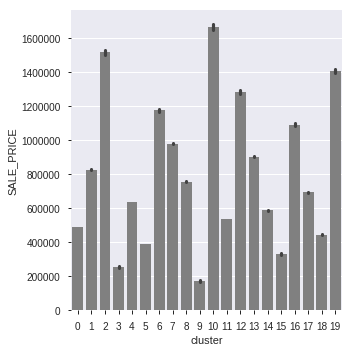

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x = "cluster",y = "SALE_PRICE",data = train, kind = "bar", color = "grey");

In [238]:
train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE', 'Gross_feet_binned', 'cluster'],
      dtype='object')

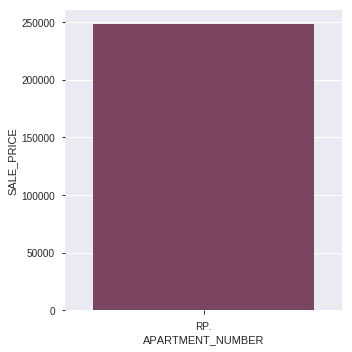

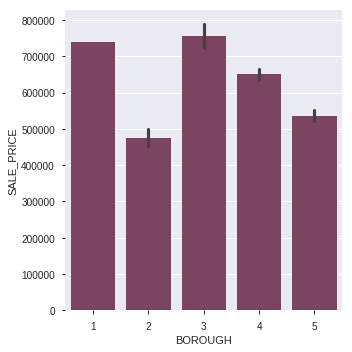

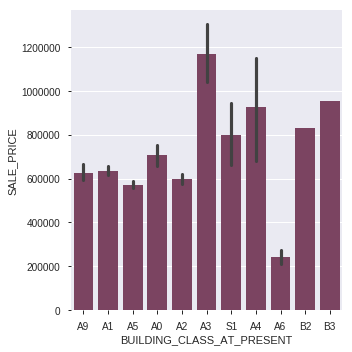

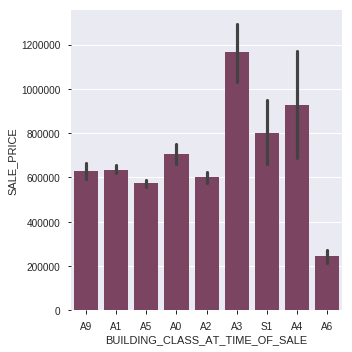

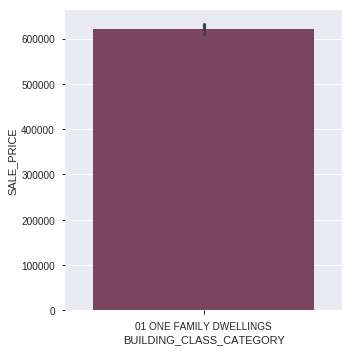

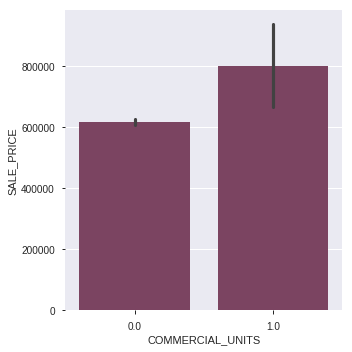

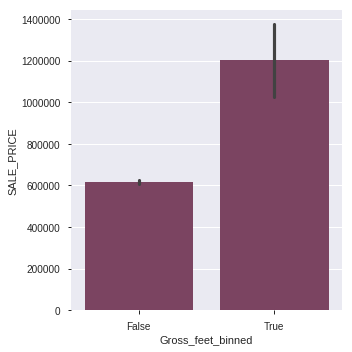

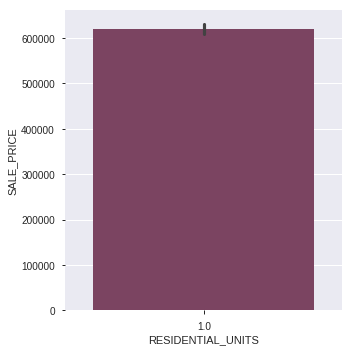

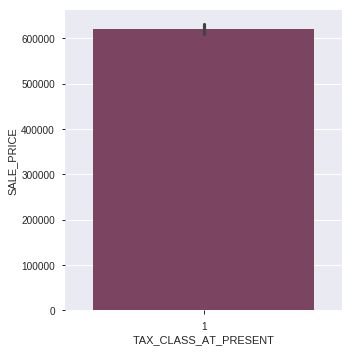

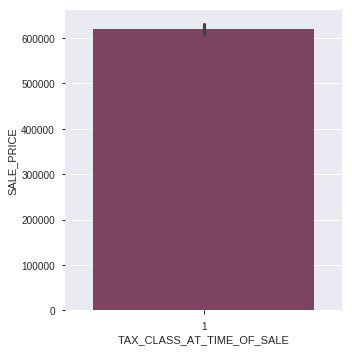

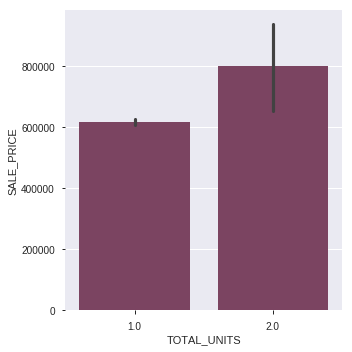

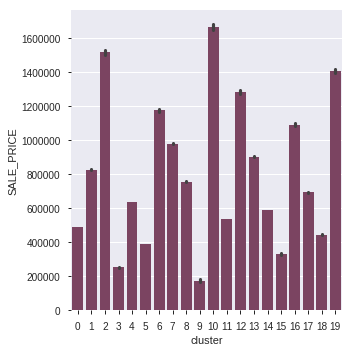

In [239]:
# exploring other data compared to the price 

for col in sorted(train.columns.drop(["EASE-MENT","SALE_PRICE"])):
  if train[col].nunique() <= 20:
    sns.catplot(x = col ,y = "SALE_PRICE",data = train, kind = "bar", color = "#843B62");
    plt.show()

In [240]:
train["BOROUGH"] = train["BOROUGH"].astype(str)
test["BOROUGH"] = test["BOROUGH"].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [241]:
# cardinality for categorical data 
train.describe(exclude = "number").T.sort_values(by = "unique")

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2455,1,01 ONE FAMILY DWELLINGS,2455,NaN,NaN
TAX_CLASS_AT_PRESENT,2455,1,1,2455,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
Gross_feet_binned,2455,2,False,2442,NaN,NaN
BOROUGH,2455,5,4,1173,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2455,9,A1,912,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2455,11,A1,912,NaN,NaN
SALE_DATE,2455,67,2019-01-31 00:00:00,77,2019-01-01 00:00:00,2019-03-29 00:00:00
NEIGHBORHOOD,2455,175,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2455,878,"4,000",231,NaN,NaN


In [0]:
target = "SALE_PRICE"
numerics = train.select_dtypes(include = "number").columns.drop(target).tolist()
categoricals = train.select_dtypes(exclude = "number").columns.tolist()
low_cardinalality = [col for col in categoricals if train[col].nunique() <= 50]

features = numerics + low_cardinalality
features.remove("Gross_feet_binned")


In [257]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape,y_test.shape

((2455, 17), (2455,), (630, 17), (630,))

In [258]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.head()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,cluster,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6
44,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,11,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
61,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,9,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
78,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
108,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,9,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,4,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [0]:
X_train_encoded = X_train_encoded.drop(columns='EASE-MENT')
X_test_encoded = X_test_encoded.drop(columns='EASE-MENT')

In [260]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
  print(f"{k} features")
  
  selector = SelectKBest(score_func = f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)
  
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test,y_pred)
  print(f"Test MAE: ${mae:,.0f}")
  print()


1 features
Test MAE: $179,991

2 features
Test MAE: $177,896

3 features
Test MAE: $177,896

4 features
Test MAE: $180,654

5 features
Test MAE: $182,066

6 features
Test MAE: $181,345

7 features
Test MAE: $184,508

8 features
Test MAE: $170,331

9 features
Test MAE: $170,032

10 features
Test MAE: $170,044

11 features
Test MAE: $160,852

12 features
Test MAE: $160,790

13 features
Test MAE: $160,952

14 features
Test MAE: $160,857

15 features
Test MAE: $160,823

16 features
Test MAE: $160,547

17 features
Test MAE: $160,785

18 features
Test MAE: $160,730

19 features
Test MAE: $758,464,824,160,063

20 features
Test MAE: $396,728,891,386,718

21 features
Test MAE: $160,570

22 features
Test MAE: $2,385,609,603,626,905

23 features
Test MAE: $994,919,661,056,083

24 features
Test MAE: $465,810,105,135,192

25 features
Test MAE: $161,203

26 features
Test MAE: $161,310

27 features
Test MAE: $162,380

28 features
Test MAE: $162,486

29 features
Test MAE: $418,955,102,743,490,624

30 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/p

Test MAE: $162,007,374,111,649,920

36 features
Test MAE: $21,195,002,490,815,148

37 features
Test MAE: $96,838,669,370,119,072

38 features
Test MAE: $57,426,746,416,326,080

39 features
Test MAE: $1,328,200,948,988,210,944



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/p